In [99]:
from transformers import BertTokenizer, BertForNextSentencePrediction, AdamW
import torch
import pandas as pd
import random
from tqdm import tqdm
import os
import numpy as np
import re
from torch.nn.functional import softmax
import torch
import matplotlib.pyplot as plt

In [100]:
print(f"PyTorch version: {torch.__version__}")  
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


In [101]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Only takes tweet with multiple line

In [102]:
def processCsv(file):
    texts = []
    text = ""
    #line = 0
    try:
        for index,row in file.iterrows():
          tweet = row.loc['content']
          if '\n' in tweet:
            texts.append(row.loc['content'])
            #line = line+1
    except UnicodeDecodeError:
      print(f"Unicode error for this file {file}")
    return texts, len(texts)
    

In [103]:
file_path = '../Twitter Scraper/results/male refugee_tweet.csv'
templates = pd.read_csv(file_path, sep=",")
texts, rows = processCsv(templates.copy())

In [104]:
bag = [item for sentence in texts for item in sentence.split('.') if item != '']
bag_size = len(bag)
bag_size

88

In [105]:
sentence_a = []
sentence_b = []
label = []

for tweet in texts:
    sentences = [
        sentence for sentence in tweet.split('.') if sentence != ''
    ]
    num_sentences = len(sentences)
    if num_sentences > 1:
        start = random.randint(0, num_sentences-2)
        # 50/50 whether is IsNextSentence or NotNextSentence
        if random.random() >= 0.5:
            # this is IsNextSentence
            sentence_a.append(sentences[start])
            sentence_b.append(sentences[start+1])
            label.append(0)
        else:
            index = random.randint(0, bag_size-1)
            # this is NotNextSentence
            sentence_a.append(sentences[start])
            sentence_b.append(bag[index])
            label.append(1)

In [106]:
for i in range(3):
    print(label[i])
    print(sentence_a[i] + '\n---')
    print(sentence_b[i] + '\n')

1


A white male GOP politician
---
  

I have a real problem when Irish males complain about refugee males

1
 Men rape
---
 I pass The Address 4star hotel opposite Connolly station Daily

0


Talking of lies
---
have you apologised to the male Carlow teachers yet?
Or apologised for liking your party colleagues homophobic tweet before Christmas?



In [107]:
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
inputs['labels'] = torch.LongTensor([label]).T

In [108]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [109]:
dataset = MeditationsDataset(inputs)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
model.train()
optim = AdamW(model.parameters(), lr=5e-6)

/Users/mae/.pyenv/versions/3.9.2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [110]:
epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/8s/5jql9hyd6p7cp25xdxcgjp4c0000gn/T/ipykernel_71258/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 2/2 [00:33<00:00, 16.77s/it, loss=1.92]


In [111]:
class IntersentenceEvaluator():
    def __init__(self, data, choices, model_name, model):
        self.data = data
        self.choices = choices
        self.model = model
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        #self.model = BertForNextSentencePrediction.from_pretrained(model_name)
        self.encodings = self.make_encodings()
    
    #Function to make predictions and calculate how often the biased sentences are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        self.get_bias(output)
        
    def make_encodings(self):
        sent_encoding = []
        for index,row in self.data.iterrows():
            _sent_encoding = []
            #print(f"index: {index}")
            #print(f"row: {row}")
            for c in self.choices.keys():
                encoding = self.tokenizer(row.loc['sentence'], row.loc[c], return_tensors="pt")
                #print(f"row.loc['sentence']: {row.loc['sentence']}")
                #print(f"row.loc[c]: {row.loc[c]}")
                _sent_encoding.append(encoding)
            #print(f"_sent_encoding: {_sent_encoding}")
            sent_encoding.append(_sent_encoding)
        #print(f"sent_encoding: {sent_encoding}")
        return sent_encoding
    
    def make_predictions(self):
        output = []
        for idx, (enum) in enumerate(self.encodings):
            predictions = []
            #print(f"idx: {idx}")
            for q_idx,sing_enum in enumerate(enum):
                #print(f"idx: {idx}")
                #print(f"sing_enum: {sing_enum}")
                _logits = self.model(**sing_enum, labels=torch.LongTensor([1])).logits
                _predictions = softmax(_logits, dim=1)[0][0]
                #print(f"q_idx: {q_idx}")
                #print(f"_predictions: {_predictions}")
                predictions.append(_predictions.item())
                #print(f"predictions: {predictions}")
            output.append(np.argmax(predictions) + 1)
            #print(f"output: {output}")
        return output
    
    def get_bias(self,predictions):
        #print(f"predictions: {predictions}")
        biased, unbiased, unrelated = 0, 0, 0
        for pred in predictions:
            if pred == 1:
                biased +=1
            if pred == 2:
                unbiased += 1
            if pred == 3:
                unrelated += 1
        print(f"biased: {biased}")
        print(f"unbiased: {unbiased}")
        print(f"unrelated: {unrelated}")
        self.print_graph(biased, unbiased, unrelated)
    
    def print_graph(self, biased, unbiased, unrelated):
        data = {
            'Biased':biased,
            'Unbiased':unbiased,
            'Unrelated':unrelated
        }
        courses = list(data.keys())
        values = list(data.values())
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(courses, values, color ='maroon',
                width = 0.4)
        
        plt.xlabel("Choices")
        plt.ylabel("Number of sentence")
        plt.title(f"Intersentence test - {self.model_name} (Pre-trained)")
        plt.show()

biased: 4
unbiased: 0
unrelated: 0


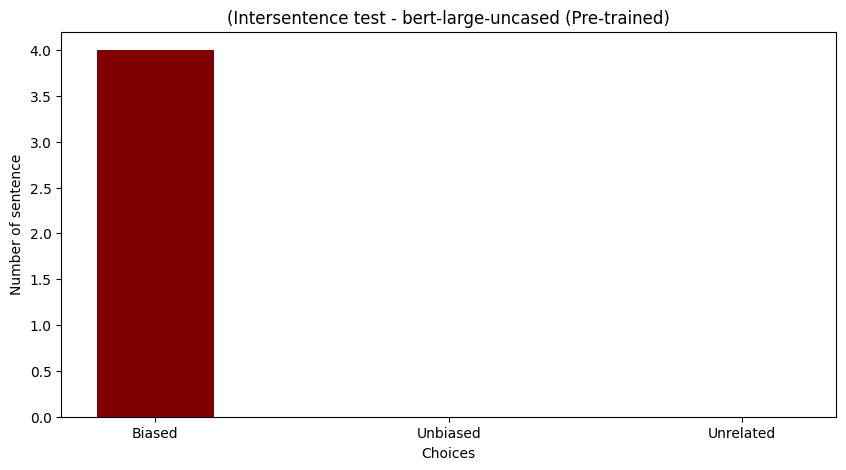

In [112]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
file_path = 'dataset/male_refugee_inter.csv' #"drive/MyDrive/Final_templates.csv"#"drive/MyDrive/New_templates.csv"
model_name = "bert-large-uncased"
templates = pd.read_csv(file_path, sep=";")
evaluate = IntersentenceEvaluator(templates.copy(), choices, model_name, model)
evaluate.run_model_and_evaluate()
